# Get feature importance / SHAP values

In [6]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as pl
import ml_help
from time import time
import seaborn as sns
sns.set_theme()

In [7]:
df = pd.read_csv("./data/gardiner_flow.csv.zip")
df["collectedAt"] = pd.to_datetime(df["collectedAt"], utc=True)
df.drop(["collectedAt"],axis=1,inplace=True)
df["Day"] = df["day"]
df["Hour"] = df["hour"]
df["Minute"] = df["minute"]
df.drop(["day","hour","minute"], inplace=True, axis=1)
df

,month,day_of_week,currentSpeed,Day,Hour,Minute
0,July,Thursday,94,14,12,45
1,July,Thursday,94,14,12,51
2,July,Thursday,75,14,12,55
3,July,Thursday,72,14,13,0
4,July,Thursday,94,14,13,5
...,...,...,...,...,...,...
73530,March,Sunday,92,26,21,35
73531,March,Sunday,92,26,21,40
73532,March,Sunday,79,26,21,45
73533,March,Sunday,92,26,21,50


In [8]:
categorical_feats = ["month","day_of_week"]

transformed_df = pd.get_dummies(df, columns=categorical_feats, prefix="", prefix_sep="")
transformed_df = transformed_df.astype("float32")
transformed_df

,currentSpeed,Day,Hour,Minute,August,December,February,January,July,March,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,94.0,14.0,12.0,45.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,94.0,14.0,12.0,51.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,75.0,14.0,12.0,55.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,72.0,14.0,13.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,94.0,14.0,13.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73530,92.0,26.0,21.0,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
73531,92.0,26.0,21.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
73532,79.0,26.0,21.0,45.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
73533,92.0,26.0,21.0,50.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
X = transformed_df.drop("currentSpeed",axis=1)
y = transformed_df["currentSpeed"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# XGBoost

Fitting...
Fitting... OK! Took 12.130024194717407 seconds
Explaining...
Explaining... OK! Took 6.800990581512451 seconds
Calculating shap values...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Calculating shap values... OK! Took 63.74792814254761 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


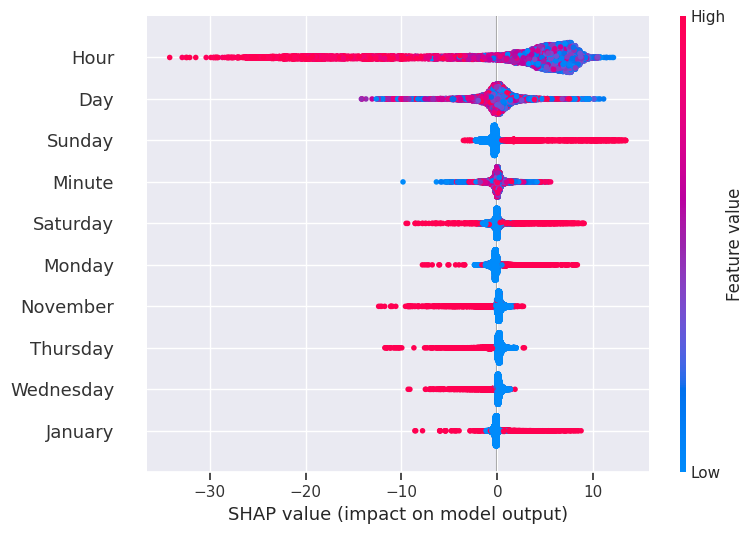

In [10]:
import xgboost as xgb

params = ml_help.params_to_dict("003_xgboost")
params['predictor'] = 'cpu_predictor'
params['tree_method'] = 'hist'
model = xgb.XGBRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
xgboost_fig = pl.gcf()
pl.savefig("./plots/006_xgboost.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/006_xgboost.png", bbox_inches="tight")
pl.savefig("./plots/006_xgboost.pdf", bbox_inches="tight")

# Random Forest

Fitting...
Fitting... OK! Took 1.0844802856445312 seconds
Explaining...
Explaining... OK! Took 0.012110233306884766 seconds
Calculating shap values...
Calculating shap values... OK! Took 49.084784507751465 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


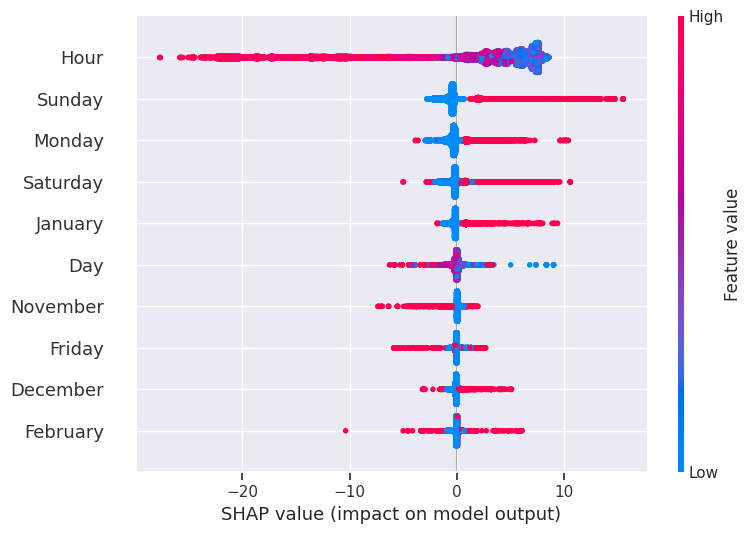

In [11]:
from sklearn.ensemble import RandomForestRegressor

params = ml_help.params_to_dict("003_random_forest")
model = RandomForestRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/006_random_forest.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/006_random_forest.png", bbox_inches="tight")
pl.savefig("./plots/006_random_forest.pdf", bbox_inches="tight")

# Decision Tree

Fitting...
Fitting... OK! Took 0.049338579177856445 seconds
Explaining...
Explaining... OK! Took 0.0006287097930908203 seconds
Calculating shap values...
Calculating shap values... OK! Took 0.25876712799072266 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


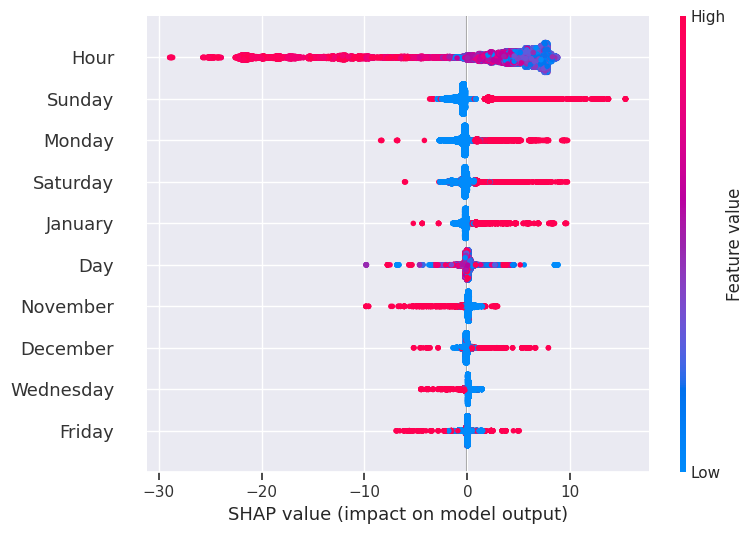

In [12]:
from sklearn.tree import DecisionTreeRegressor

params = ml_help.params_to_dict("003_decision_tree")
model = DecisionTreeRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/006_decision_tree.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/006_decision_tree.png", bbox_inches="tight")
pl.savefig("./plots/006_decision_tree.pdf", bbox_inches="tight")

# MLP

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Fitting...


X does not have valid feature names, but MLPRegressor was fitted with feature names


Fitting... OK! Took 101.88338875770569 seconds
Explaining...
Explaining... OK! Took 0.0006816387176513672 seconds
Calculating shap values...


100%|█████████████████████████████████████| 14707/14707 [03:45<00:00, 65.10it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Calculating shap values... OK! Took 225.95189261436462 seconds


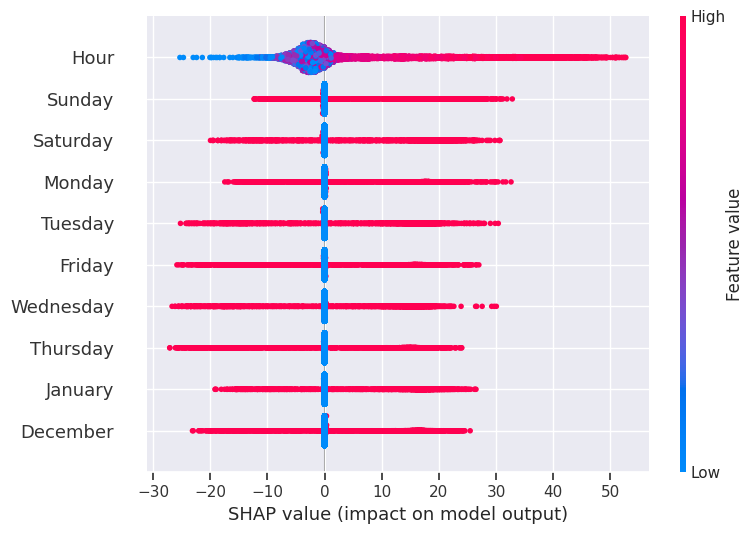

In [5]:
from sklearn.neural_network import MLPRegressor
import warnings

X_train_summary = shap.kmeans(X_train, 10)

params = ml_help.params_to_dict("003_mlpr")
model = MLPRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.KernelExplainer(model.predict, X_train_summary)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/006_mlp.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/006_mlp.png", bbox_inches="tight")
pl.savefig("./plots/006_mlp.pdf", bbox_inches="tight")